In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/svm-tv-dataset/cleaned_tv_dataset_fi.csv


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load dữ liệu & xem sơ bộ

In [3]:
df = pd.read_csv("/kaggle/input/svm-tv-dataset/cleaned_tv_dataset_fi.csv")

print("Kích thước dữ liệu:", df.shape)
display(df.head())

print("\nKiểu dữ liệu các cột:")
print(df.dtypes)

print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isna().sum())

Kích thước dữ liệu: (613, 12)


,price,spec_Backlight_Type,spec_Brand,spec_Display_Type,spec_ENERGY_STAR_Certified,spec_High_Dynamic_Range_HDR,spec_LED_Panel_Type,spec_Model_Year,spec_Refresh_Rate,spec_Remote_Control_Type,spec_Resolution,spec_Screen_Size_Class
0,139.99,Direct Lit,Pioneer,LED,No,Yes,Standard LED,2023,60,Voice control,4K (2160p),43
1,99.99,Direct Lit,TCL,LED,No,No,Standard LED,2025,144,Standard,Full HD (1080p),40
2,109.99,Direct Lit,Insignia,LED,No,No,Standard LED,2025,120,Voice control,Full HD (1080p),40
3,199.99,Direct Lit,Insignia,LED,No,Yes,Standard LED,2025,120,Voice control,4K (2160p),55
4,189.99,Direct Lit,Pioneer,LED,No,Yes,Standard LED,2023,60,Voice control,4K (2160p),50



Kiểu dữ liệu các cột:
price                          float64
spec_Backlight_Type             object
spec_Brand                      object
spec_Display_Type               object
spec_ENERGY_STAR_Certified      object
spec_High_Dynamic_Range_HDR     object
spec_LED_Panel_Type             object
spec_Model_Year                  int64
spec_Refresh_Rate                int64
spec_Remote_Control_Type        object
spec_Resolution                 object
spec_Screen_Size_Class           int64
dtype: object

Số lượng giá trị thiếu mỗi cột:
price                            0
spec_Backlight_Type            207
spec_Brand                       0
spec_Display_Type                0
spec_ENERGY_STAR_Certified       0
spec_High_Dynamic_Range_HDR      0
spec_LED_Panel_Type              0
spec_Model_Year                  0
spec_Refresh_Rate                0
spec_Remote_Control_Type         0
spec_Resolution                  0
spec_Screen_Size_Class           0
dtype: int64


# Tạo nhãn phân khúc giá: Giá rẻ / Trung cấp / Cao cấp

In [4]:
price = df["price"]

# Dùng quantile để chia 3 phân khúc
q1 = price.quantile(1/3)
q2 = price.quantile(2/3)
print("Ngưỡng phân khúc giá:")
print(f"Giá rẻ    : price <= {q1:.2f}")
print(f"Trung cấp : {q1:.2f} < price <= {q2:.2f}")
print(f"Cao cấp   : price > {q2:.2f}")

def price_to_segment(p):
    if p <= q1:
        return "Low"
    elif p <= q2:
        return "Mid"
    else:
        return "High"

df["price_segment"] = df["price"].apply(price_to_segment)

print("\nPhân bố số lượng từng lớp giá:")
print(df["price_segment"].value_counts())

Ngưỡng phân khúc giá:
Giá rẻ    : price <= 399.99
Trung cấp : 399.99 < price <= 1079.99
Cao cấp   : price > 1079.99

Phân bố số lượng từng lớp giá:
price_segment
Low     208
High    204
Mid     201
Name: count, dtype: int64


# Tiền xử lý chung: X, y, xử lý missing, One-Hot

In [5]:
target_col = "price_segment"
y = df[target_col]
X = df.drop(columns=["price", target_col])  # bỏ price liên tục & nhãn phân đoạn

# Phân loại cột numeric và categorical
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Số cột numeric:", len(numeric_cols))
print("Số cột categorical:", len(categorical_cols))

# Xử lý missing:
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

# One-Hot Encoding cho các cột phân loại
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Kích thước X sau One-Hot encoding:", X_encoded.shape)

Số cột numeric: 3
Số cột categorical: 8
Kích thước X sau One-Hot encoding: (613, 58)


# Train/Test Split (Percentage Split) + Hàm đánh giá phân lớp

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y   # giữ phân bố lớp
)

print("Train size:", X_train.shape, " - Test size:", X_test.shape)
print("Phân bố label train:")
print(y_train.value_counts())
print("\nPhân bố label test:")
print(y_test.value_counts())

def evaluate_classification(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average="weighted")
    print(f"===== {model_name} =====")
    print(f"Accuracy      : {acc:.4f}")
    print(f"F1 (weighted) : {f1_w:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))
    return {"Model": model_name, "Accuracy": acc, "F1_weighted": f1_w}

Train size: (490, 58)  - Test size: (123, 58)
Phân bố label train:
price_segment
Low     166
High    163
Mid     161
Name: count, dtype: int64

Phân bố label test:
price_segment
Low     42
High    41
Mid     40
Name: count, dtype: int64


# Thiết lập Repeated Stratified K-Fold & bộ scoring CV

In [7]:
from sklearn.metrics import make_scorer

rkf = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=3,
    random_state=RANDOM_STATE
)

scoring = {
    "Accuracy": "accuracy",
    "F1_weighted": make_scorer(f1_score, average="weighted")
}

# Tuning tham số SVM bằng RandomizedSearchCV + Repeated Stratified K-Fold
Tuning C, gamma, kernel

In [8]:
from scipy.stats import loguniform

# Pipeline SVM: scaler + SVC
svm_for_search = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=False, random_state=RANDOM_STATE))
])

param_distributions = {
    "svc__C": loguniform(0.1, 100),           # C từ 0.1 đến 100 (log-scale)
    "svc__gamma": loguniform(1e-4, 1e-1),     # gamma nhỏ cho RBF
    "svc__kernel": ["rbf"]                    # chủ yếu dùng rbf cho bài toán này
}

svm_random_search = RandomizedSearchCV(
    estimator=svm_for_search,
    param_distributions=param_distributions,
    n_iter=30,                  # số lần thử; có thể tăng nếu thời gian cho phép
    scoring="f1_weighted",      # tối ưu F1 weighted
    cv=rkf,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

svm_random_search.fit(X_train, y_train)

print("Best params:", svm_random_search.best_params_)
print("Best CV F1_weighted:", svm_random_search.best_score_)

svm_best = svm_random_search.best_estimator_

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Best params: {'svc__C': 15.702970884055382, 'svc__gamma': 0.006251373574521752, 'svc__kernel': 'rbf'}
Best CV F1_weighted: 0.802817898857913


# Đánh giá SVM Best trên Percentage Split (PS)

In [9]:
y_pred_best_ps = svm_best.predict(X_test)
metrics_best_ps = evaluate_classification(y_test, y_pred_best_ps, model_name="SVM Tuned (PS)")

===== SVM Tuned (PS) =====
Accuracy      : 0.8374
F1 (weighted) : 0.8393

Classification report:
              precision    recall  f1-score   support

        High       0.87      0.83      0.85        41
         Low       0.93      0.88      0.90        42
         Mid       0.73      0.80      0.76        40

    accuracy                           0.84       123
   macro avg       0.84      0.84      0.84       123
weighted avg       0.84      0.84      0.84       123



# Cross Validation cho SVM Best với Repeated Stratified K-Fold

In [10]:
cv_results_best = cross_validate(
    svm_best,
    X_train,
    y_train,
    cv=rkf,
    scoring=scoring,
    n_jobs=-1
)

acc_cv_mean = cv_results_best["test_Accuracy"].mean()
acc_cv_std  = cv_results_best["test_Accuracy"].std()

f1_cv_mean = cv_results_best["test_F1_weighted"].mean()
f1_cv_std  = cv_results_best["test_F1_weighted"].std()

print("===== SVM Tuned - Repeated Stratified K-Fold CV (TRAIN) =====")
print(f"Accuracy (mean ± std): {acc_cv_mean:.4f} ± {acc_cv_std:.4f}")
print(f"F1_weighted (mean ± std): {f1_cv_mean:.4f} ± {f1_cv_std:.4f}")
print("Accuracy từng run:", cv_results_best["test_Accuracy"])
print("F1_weighted từng run:", cv_results_best["test_F1_weighted"])

===== SVM Tuned - Repeated Stratified K-Fold CV (TRAIN) =====
Accuracy (mean ± std): 0.8020 ± 0.0316
F1_weighted (mean ± std): 0.8028 ± 0.0320
Accuracy từng run: [0.78571429 0.79591837 0.85714286 0.79591837 0.75510204 0.86734694
 0.81632653 0.80612245 0.75510204 0.79591837 0.80612245 0.80612245
 0.7755102  0.83673469 0.7755102 ]
F1_weighted từng run: [0.78886338 0.79828651 0.85835073 0.79378037 0.75776838 0.86913939
 0.81591625 0.80638489 0.75162182 0.79689376 0.80777809 0.80675039
 0.77807499 0.83796003 0.7746995 ]


# Confusion Matrix & F1 theo lớp cho SVM Tuned (PS)

<Figure size 500x500 with 0 Axes>

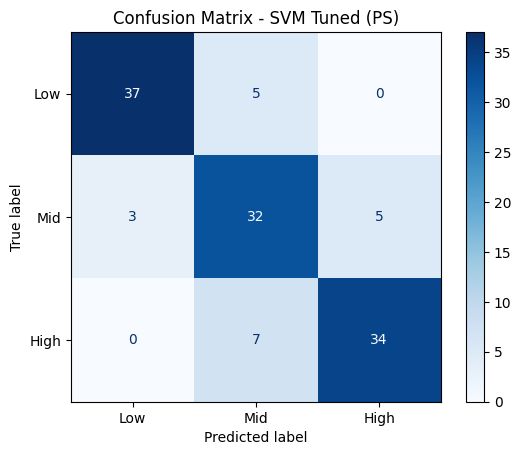

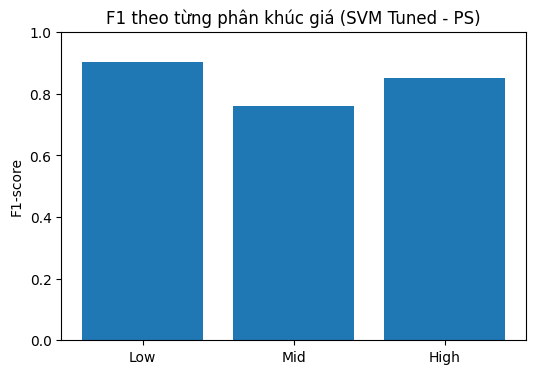

In [11]:
# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best_ps, labels=["Low", "Mid", "High"])
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["Low", "Mid", "High"])

plt.figure(figsize=(5, 5))
disp_best.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - SVM Tuned (PS)")
plt.show()

# F1-score theo từng lớp
report_dict = classification_report(y_test, y_pred_best_ps, output_dict=True)
labels = ["Low", "Mid", "High"]
f1_per_class = [report_dict[label]["f1-score"] for label in labels]

plt.figure(figsize=(6,4))
plt.bar(labels, f1_per_class)
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("F1 theo từng phân khúc giá (SVM Tuned - PS)")
plt.show()

In [12]:
# ============================================================
# Cell - Save mô hình SVM Tuned (svm_best) để deploy web
# ============================================================

import joblib
import json

# 1) Lưu mô hình SVM đã tuning
joblib.dump(svm_best, "svm_best_model.pkl")
print("Đã lưu model: svm_best_model.pkl")

# 2) Lưu danh sách cột sau One-Hot encoding
#    -> cực kỳ quan trọng khi deploy vì phải encode input giống lúc train
feature_cols = list(X_train.columns)

with open("svm_feature_columns.json", "w") as f:
    json.dump(feature_cols, f)

print("Đã lưu feature cols: svm_feature_columns.json")


Đã lưu model: svm_best_model.pkl
Đã lưu feature cols: svm_feature_columns.json
